<a href="https://colab.research.google.com/github/Cyporg53/machine-learning/blob/main/Week_6_Mnist_notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

First we will need to import tensorflow so that we can use it to train a machine learning model that can classify hand written digits.

We will also import the tensorflow datasets library so that we can load our dataset.

Finally, we import matplotlib, which we will use to display the images.

In [ ]:
import tensorflow as tf
import tensorflow_datasets as tfds

import matplotlib.pyplot as plt

Let's load our data.

We will use the function `tfds.load()` to get a nicely prepackaged and cleaned dataset. Let's take a look at the parameters we pass to this function.

1. `'mnist`' - this downloads the MNIST dataset, which is the dataset we want. There are a lot of other datasets available but each of them require a different approach so we will focus on just mnist for today.
2. `split=['train', 'test]` this splits our training data into two parts, a train set and a test set. The trainset has 60,000 examples and the test set has 10,000. This allows us to check our work
3. `shuffle_files=True` will make sure we shuffle our data up. We don't want our nueral network to guess what digit it is looking at based on the previous number it looked at. If we didn't shuffle, the nueral network would just learn that if the last number it saw was a 5, for example, the next number must be 6, and so forth.
4. `as_supervised=True` just makes the format of the data equivlant to a bunch of tuples of the form: `(image of digit, label of digit)`.
5. `with_info` will grab some more info about the dataset for us to look at.



Feel free to read up more about the MNIST dataset at this link: https://www.tensorflow.org/datasets/catalog/mnist or read more about it by running the cell below to see `dataset_info`.

In [ ]:
(dataset_train, dataset_test), dataset_info = tfds.load(
    'mnist',
    split=['train', 'test'],
    shuffle_files=True,
    as_supervised=True,
    with_info=True,
)

In [ ]:
dataset_info

tfds.core.DatasetInfo(
    name='mnist',
    full_name='mnist/3.0.1',
    description="""
    The MNIST database of handwritten digits.
    """,
    homepage='http://yann.lecun.com/exdb/mnist/',
    data_dir='/root/tensorflow_datasets/mnist/3.0.1',
    file_format=tfrecord,
    download_size=11.06 MiB,
    dataset_size=21.00 MiB,
    features=FeaturesDict({
        'image': Image(shape=(28, 28, 1), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=10),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'test': <SplitInfo num_examples=10000, num_shards=1>,
        'train': <SplitInfo num_examples=60000, num_shards=1>,
    },
    citation="""@article{lecun2010mnist,
      title={MNIST handwritten digit database},
      author={LeCun, Yann and Cortes, Corinna and Burges, CJ},
      journal={ATT Labs [Online]. Available: http://yann.lecun.com/exdb/mnist},
      volume={2},
      year={2010}
    }""",
)

Next we are going to prepare our dataset so that we can use it to train our model.

Let's first take a look at the first example in our dataset.
The first element is a tuple, with two elements as you can see in the code cell below.

Each element in our dataset is of type: <class 'tuple'>
The label of this element is: tf.Tensor(4, shape=(), dtype=int64)
The shape of this image is: (28, 28, 1)


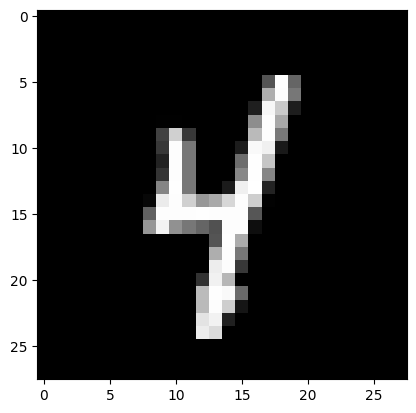

In [ ]:
for x in dataset_train:
    img, label = x
    plt.imshow(img[:,:,0], cmap='gray')

    print("Each element in our dataset is of type:", type(x))
    print("The label of this element is:", label)
    print("The shape of this image is:", img.shape)

    break

First we need to convert the data type of the images from unsigned 8-bit integers to 32-bit float. This is because the nueral network we will use expects 32-bit floats.

Next we will devide the images by 255 because that will keep all the values in the image between 0 and 1 rather than between 0 and 255.
Having smaller values allows training to go faster.

We also batch our data. This means we split our 60,000 training examples into batches or groups of 128 examples and train on those. This allows our model to view 128 different images and their labels at once and learn from them all at the same time. This means it will be almost 128x as fast to train!

In [ ]:
def normalize_img(image, label):
    """Normalizes images from unsigned 8-bit integers to 32-bit float.
    Also scales all values to be between 0 and 1 rather than 0 and 255."""
    image = tf.cast(image, tf.float32)

    # rescale the image to be between 0 and 1 by dividing it by 255
    image = image / 255 # DO THIS TO SPEED UP TRAINING PROCESS SINCE SMALLER NUMBER SIZES

    return image, label

# apply our normalization function to our dataset
dataset_train = dataset_train.map(normalize_img)

# next we shuffle up our training data again
dataset_train = dataset_train.shuffle(dataset_info.splits['train'].num_examples)

# finally we batch our data to allow us to train faster
dataset_train = dataset_train.batch(128)


# do the same for our testing data. Make sure to normalize it and to batch it only
# no need to shuffle.
dataset_test = dataset_test.map(normalize_img)
dataset_test = dataset_test.batch(128)

Time to make our model, the fun part!

Our model is sequential. This means that data only flows one way. In other words, the model guesses what the image but its current guess doesn't affect its next guess.

Next, we flatten the input to the model. This means we take our image that is 28 by 28 pixels and convert it to one long list that is 784 (28 x 28) long.

Then we take that 784 long list and use that as input to our first dense, or fully connected layer. This layer has 128 nuerons, hence the 128. The relu activation is a function. Feel free to read more about it [here](https://en.wikipedia.org/wiki/Rectifier_(neural_networks)).

Finally, we have one more dense layer which has 10 nuerons. This is our output layer. Each of these neurons in the output layer represent how likely a digit (numbered 0 through 9) is to be the number written in the input image. In other words, if the 0th nueron is the largest number, then 0 is the digit the model guesses is in the image.

In [ ]:
# You can create your own model by changing the numbers of neurons, adding more layers, and using different acitvation functions.
# play around with it and see what accuracy you can acheieve in the next steps!

model = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=(28, 28)),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(10)
])

Now we will compile our model, which allows us to actually train our model.

The optimizer is what looks at how accurate our model is and modifies the weights and biases to make our model more accurate. The loss parameter is a function that determines how inaccurate our model is on each prediction. The optimizer uses this value from the loss function to make tweaks.

In [ ]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(0.001),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=["accuracy"]
)

Let's check to see how accurate it is before we even start training. We can expect it to be somwhere around 10% accurate because there are 10 possible digits and the intial values in the model are assigned randomly.

If you run the last few cells a few different times you will notice your accuracy is different everytime depending on what random values the model starts with.

In [ ]:
results = model.evaluate(dataset_train)
print("Our training loss and accuracy:", results)

results = model.evaluate(dataset_test)
print("Our testing loss and accuracy:", results)

469/469 [==============================] - 16s 7ms/step - loss: 2.3573 - accuracy: 0.1094
Our training loss and accuracy: [2.357283353805542, 0.10938332974910736]
79/79 [==============================] - 2s 16ms/step - loss: 2.3600 - accuracy: 0.1126
Our testing loss and accuracy: [2.3599555492401123, 0.11259999871253967]


Finally, we can train our model. We will train it on our training dataset and we will check to see how accurate we are after each epoch using our testing dataset. It is important to remember that we only use the values in the training dataset to make improvements to our model and we will only use the testing dataset to see our accuracy.

Each epoch is one complete use of the entire dataset to train. We will train on the entire dataset 8 times, after which we have acheieved a very high accuracy.

In [ ]:
history = model.fit(
    # which dataset should we use to train?
    dataset_train,

    epochs=8,
    validation_data=dataset_test,
)

Epoch 1/8
469/469 [==============================] - 7s 6ms/step - loss: 0.3630 - accuracy: 0.8985 - val_loss: 0.2022 - val_accuracy: 0.9411
Epoch 2/8
469/469 [==============================] - 6s 8ms/step - loss: 0.1748 - accuracy: 0.9502 - val_loss: 0.1445 - val_accuracy: 0.9587
Epoch 3/8
469/469 [==============================] - 5s 5ms/step - loss: 0.1255 - accuracy: 0.9637 - val_loss: 0.1183 - val_accuracy: 0.9652
Epoch 4/8
469/469 [==============================] - 6s 6ms/step - loss: 0.0973 - accuracy: 0.9725 - val_loss: 0.0999 - val_accuracy: 0.9697
Epoch 5/8
469/469 [==============================] - 6s 7ms/step - loss: 0.0782 - accuracy: 0.9773 - val_loss: 0.0863 - val_accuracy: 0.9733
Epoch 6/8
469/469 [==============================] - 5s 6ms/step - loss: 0.0655 - accuracy: 0.9816 - val_loss: 0.0843 - val_accuracy: 0.9741
Epoch 7/8
469/469 [==============================] - 5s 6ms/step - loss: 0.0553 - accuracy: 0.9841 - val_loss: 0.0762 - val_accuracy: 0.9770
Epoch 8/8
469

Can you guess why the accuracy from our training dataset is high than our testing dataset accuracy?

In [ ]:
results = model.evaluate(dataset_train)
print("Our training loss and accuracy:", results)

results = model.evaluate(dataset_test)
print("Our testing loss and accuracy:", results)

469/469 [==============================] - 4s 3ms/step - loss: 0.0368 - accuracy: 0.9904
Our training loss and accuracy: [0.03679648041725159, 0.9903500080108643]
79/79 [==============================] - 1s 6ms/step - loss: 0.0734 - accuracy: 0.9786
Our testing loss and accuracy: [0.07342719286680222, 0.978600025177002]


Now let's graph the history of the accuracy over each of the epochs.

As you can see, our accuracy improves overtime, as does the validation accuracy.
Even though our accuracy was only arround 10% before we started training, by the end of the 0th epoch, we already got to 90% accuracy.

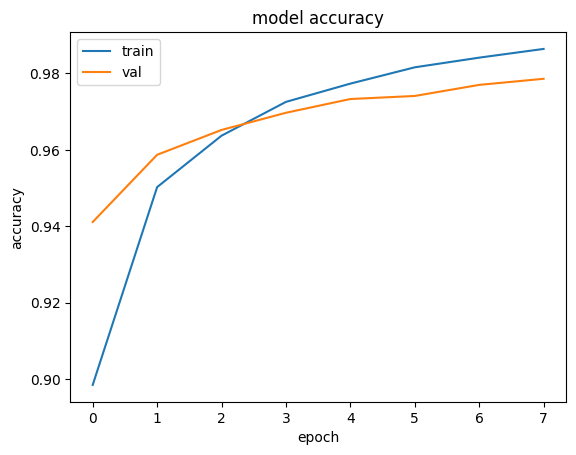

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='best')
plt.show()

Now let's use our model to make predictions on our test set and display them.


To do so, we first unbatch our test dataset so we only grab a random sample of 1 image and label at a time instead of 128 of them.

Next we use the model to make a prediction on the image. We can print out that prediction but it isn't very useful to us humans yet. We need to first take the arg-max, or the index position of the maximum value of the prediction.

In [ ]:
dataset_test = dataset_test.unbatch()
dataset_test = dataset_test.shuffle(buffer_size=dataset_info.splits['test'].num_examples)

Feel free to run this as many times as you want to see different images and the model's predictions.
Are there times when the model does better than you, or when you do better than it?


(1, 28, 28, 1) ()
1/1 [==============================] - 0s 92ms/step
This is the prediction without it being processed first:
 [[-14.354522    8.20738    -5.6078725  -2.110029   -2.1062837  -3.3564649
   -7.880812   -5.9052634  -0.6353494  -3.6487067]]

The model's prediction for the image: 1
The actual label: 1


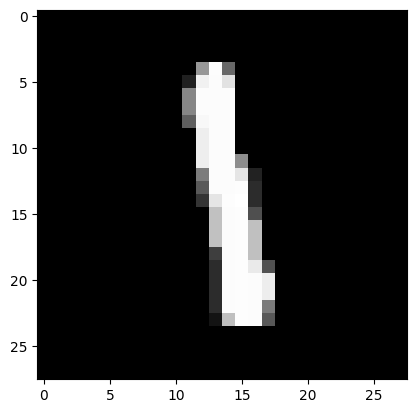

In [ ]:
def random_prediction():
    img, label = list(dataset_test.take(1))[0]
    img = tf.reshape(img, (-1, 28, 28, 1))
    print(img.shape, label.shape)

    prediction = model.predict(img)
    print("This is the prediction without it being processed first:\n", prediction)

    processed_prediction = tf.math.argmax(prediction[0])

    print("\nThe model's prediction for the image:", int(processed_prediction))
    print("The actual label:", int(label))
    plt.imshow(img[0,:,:,0], cmap="gray")


random_prediction()